In [ ]:
# This script is meant for creating synthetic spatial counts

In [3]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'

import pymc as pm

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir('/lustre/scratch/kiviaho/spatac/')
date = 20221104
sp_data_folder ='synthetic-spatial/'

In [90]:

## simulation settings
seed = 25343 # changed from 253286
n_locations = [100, 100] # 50*50 grid
n_experiments = 1 # Changed from 10

# sparsity and tissue zones
n_tissue_zones = 4 # Changed from 12
n_uniform = 0 # Changed from 8

# low and high density cell types
p_high_density = 0.2 # Changed from 0.2, 
mu_low_density = 1.0
mu_high_density = 2.8

In [3]:
# READ Visium in adata_vis
# Reading the data in
adata_vis = ad.read('data/spatial/cell2location/cell2location_multiexperiment_model_for_synthetic_data/sp.h5ad')
# Change gene index to SYMBOL for matching further down the line
adata_vis.var['ENSEMBL'] = adata_vis.var.index
symbol_index = pd.Index(adata_vis.var['SYMBOL'],dtype='str')
adata_vis.var.index = symbol_index
adata_vis.var.index = adata_vis.var.index.rename('Gene')

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gene_level_alpha_hyp, gene_level_beta_hyp]
INFO:pymc:NUTS: [gene_level_alpha_hyp, gene_level_beta_hyp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


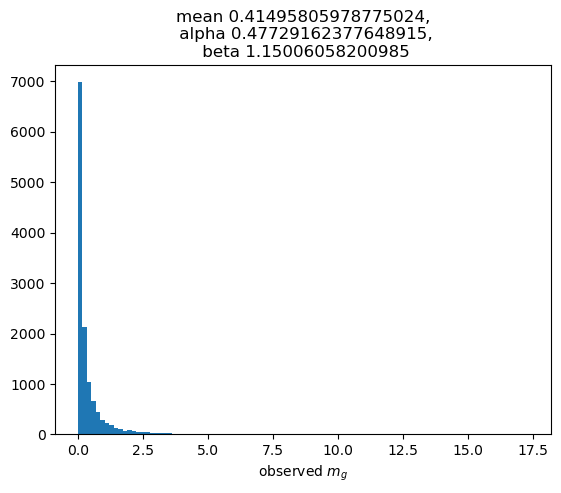

In [61]:
# put observed gene levels to data frame
gene_level_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['m_g'].T,
                          index=adata_vis.var.index,
                          columns=['gene_level'])

with pm.Model() as model:
    gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp', 1, 1, shape=(1, 1))
    gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 1, 1, shape=(1, 1))
    # global gene levels
    gene_level = pm.Gamma('gene_level', gene_level_alpha_hyp,
                          gene_level_beta_hyp, shape=(gene_level_df.shape[0], 1),
                          observed=gene_level_df.values)
    
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)
    

plt.hist(gene_level_df.values.flatten(), bins=100);
plt.xlabel(r'observed $m_g$')
plt.title(f'mean {gene_level_df.values.mean()},\n alpha {posterior.posterior.gene_level_alpha_hyp.mean()},\n beta {posterior.posterior.gene_level_beta_hyp.mean()}');


In [91]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
n_cell_types = rna.obs['broad_celltype'].value_counts().shape[0]
n_sparse = n_cell_types - n_uniform
n_zones_per_cell_type = np.random.binomial(n_tissue_zones, 0.02, size=n_sparse)+1
experiment_id = np.repeat(np.arange(n_experiments), np.prod(n_locations))
cell_types = np.array(rna.obs['broad_celltype'].unique())
uniform_cell_types = np.random.choice(cell_types, n_uniform, replace=False)
sparse_cell_types = cell_types[~np.isin(cell_types, uniform_cell_types)]

# generate matrix of which cell types are in which zones
cell_types2zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'tissue_zone_{i}' for i in range(n_tissue_zones)] \
                                + [f'uniform_{i}' for i in range(n_uniform)])
for i, n in enumerate(n_zones_per_cell_type):
    pos = np.random.randint(n_tissue_zones, size=n)
    cell_types2zones.iloc[i,pos] = 1
    
# and which uniform cell types belong to which uniform pattern
for i in range(n_uniform):
    cell_types2zones.iloc[n_sparse+i, n_tissue_zones+i] = 1
    
cell_types2zones.sum(), cell_types2zones.sum(1)

(tissue_zone_0    2
 tissue_zone_1    1
 tissue_zone_2    1
 dtype: int64,
 EN       1
 IN       1
 OG1      1
 A1.E1    1
 dtype: int64)

In [72]:
np.random.seed(seed)
# Assign cell types to either high or low density, balanced by uniform / tissue zone
high_density_cell_types = list(np.random.choice(uniform_cell_types, 
                                                int(np.round(n_uniform * p_high_density)), 
                                                replace=False))
for z, n in cell_types2zones.sum().items():
    
    ct = list(np.random.choice(cell_types2zones.index[cell_types2zones[z] > 0], 
                                                int(np.round(n * p_high_density)), 
                                                replace=False))
    print(ct)
    high_density_cell_types = high_density_cell_types + ct
    
low_density_cell_types = cell_types[~np.isin(cell_types, high_density_cell_types)]
    
# what proportion of cells are uniform?
len(high_density_cell_types) / len(cell_types)

['OG1']
[]
[]


0.25

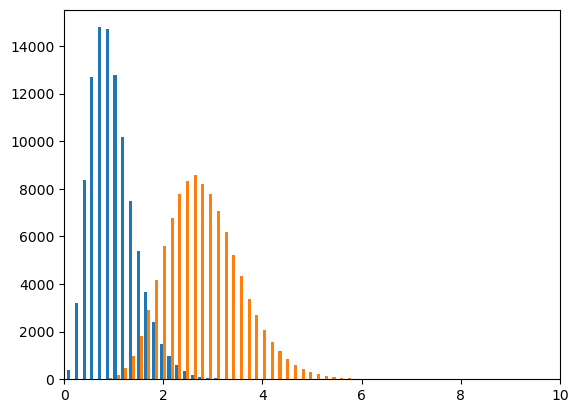

In [73]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5
plt.hist([np.random.gamma(mu_low_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5)),
          np.random.gamma(mu_high_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5))], bins=50);
plt.xlim(0, 10);

cell_types2zones.loc[low_density_cell_types] = cell_types2zones.loc[low_density_cell_types] \
 * np.random.gamma(mu_low_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(low_density_cell_types), 1))

cell_types2zones.loc[high_density_cell_types] = cell_types2zones.loc[high_density_cell_types] \
 * np.random.gamma(mu_high_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(high_density_cell_types), 1))